<a href="https://colab.research.google.com/github/Triniti0/klasifikasi-penyakit-daun-cabai/blob/main/Eksperimen_Optimasi_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inisiasi

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import numpy as np
import os
import time
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

Mounted at /content/drive


In [2]:
EXPERIMENT_NAME = "Two_Stage_Training"
BASE_SAVE_DIR = "/content/drive/MyDrive/Seminar Hasil/Experiments"

SAVE_DIR = os.path.join(BASE_SAVE_DIR, EXPERIMENT_NAME)
os.makedirs(SAVE_DIR, exist_ok=True)

RESULTS_FILE = os.path.join(SAVE_DIR, "results.csv")
BEST_MODEL_INFO = os.path.join(SAVE_DIR, "best_model_info.json")

# Load Dataset

In [3]:
IMG_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE

def load_dataset(batch_size):

    train_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/train",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/val",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/test",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        shuffle=False
    )

    class_names = train_ds.class_names

    def preprocess(x, y):
        return preprocess_input(x), y

    train_ds = train_ds.map(preprocess).prefetch(AUTOTUNE)
    val_ds = val_ds.map(preprocess).prefetch(AUTOTUNE)
    test_ds = test_ds.map(preprocess).prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

# Model Two Stage Training

In [4]:
def build_model(num_classes, dropout_rate):

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)

    return model, base_model

In [5]:
#cosine annealing untuk stage 2
def cosine_annealing(epoch, lr):
    initial_lr = 1e-5
    total_epochs = 50
    return initial_lr * (1 + np.cos(np.pi * epoch / total_epochs)) / 2

# Pelatihan Model
pelatihan dibagi atas 2 tahapan, stage 1: Feature Extraction, stage 2: fine-tuning

In [6]:
# ===== STAGE 1 =====
train_ds, val_ds, test_ds, class_names = load_dataset(32)
num_classes = len(class_names)

model, base_model = build_model(num_classes, dropout_rate=0.4)

# Freeze all conv
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_stage1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks_stage1
)

Found 11704 files belonging to 8 classes.
Found 617 files belonging to 8 classes.
Found 620 files belonging to 8 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
366/366 ━━━━━━━━━━━━━━━━━━━━ 286s 726ms/step - accuracy: 0.8101 - loss: 0.5740 - val_accuracy: 0.9708 - val_loss: 0.0913 - learning_rate: 0.0010
Epoch 2/25
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9746 - loss: 0.0837 - val_accuracy: 0.9724 - val_loss: 0.0825 - learning_rate: 0.0010
Epoch 3/25
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9864 - loss: 0.0472 - val_accuracy: 0.9789 - val_loss: 0.0509 - learning_rate: 0.0010
Epoch 4/25
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9874 - loss: 0.0395 - val_accuracy: 0.9789 - val_loss: 0.0794 - learning_rate: 0.0010
Epoch 5/25
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9926 - loss: 0.0242 - val_accuracy: 0.9741 - val_loss: 0.0759 - learning_rate: 0.0010
Epoch 6/25
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - a

In [7]:
# ===== STAGE 2 =====
# Unfreeze 30% akhir
total_layers = len(base_model.layers)
freeze_until = int(total_layers * 0.7)

for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

for layer in base_model.layers[freeze_until:]:
    layer.trainable = True

# Reload dataset dengan batch size 16
train_ds, val_ds, test_ds, class_names = load_dataset(16)

model.compile(
    optimizer=tf.keras.optimizers.SGD(1e-5, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_stage2 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    LearningRateScheduler(cosine_annealing)
]

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_stage2
)

Found 11704 files belonging to 8 classes.
Found 617 files belonging to 8 classes.
Found 620 files belonging to 8 classes.
Epoch 1/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 64s 56ms/step - accuracy: 0.7115 - loss: 1.2836 - val_accuracy: 0.9789 - val_loss: 0.0589 - learning_rate: 1.0000e-05
Epoch 2/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9317 - loss: 0.1969 - val_accuracy: 0.9789 - val_loss: 0.0673 - learning_rate: 9.9901e-06
Epoch 3/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9442 - loss: 0.1654 - val_accuracy: 0.9789 - val_loss: 0.0690 - learning_rate: 9.9606e-06
Epoch 4/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9586 - loss: 0.1300 - val_accuracy: 0.9806 - val_loss: 0.0680 - learning_rate: 9.9114e-06
Epoch 5/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9579 - loss: 0.1246 - val_accuracy: 0.9789 - val_loss: 0.0672 - learning_rate: 9.8429e-06
Epoch 6/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9651 - loss: 0.1076 

In [8]:
#simpan model
model_filename = f"Best_Model_{EXPERIMENT_NAME}.h5"
model_path = os.path.join(SAVE_DIR, model_filename)

model.save(model_path)

best_metadata = {
    "Experiment_Name": EXPERIMENT_NAME,
    "Model Path": model_path
}

with open(BEST_MODEL_INFO, "w") as f:
    json.dump(best_metadata, f, indent=4)

print("Model Saved:", model_filename)

Model Saved: Best_Model_Two_Stage_Training.h5


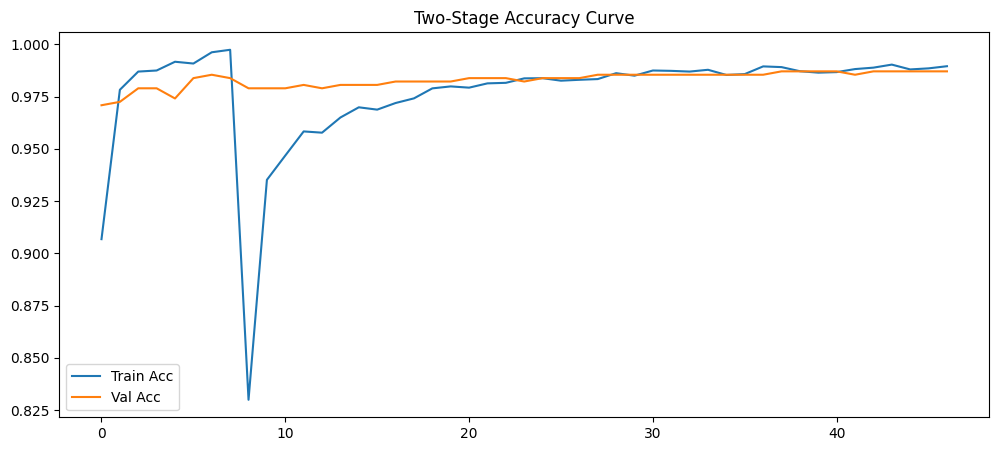

In [9]:
plt.figure(figsize=(12,5))

plt.plot(history1.history["accuracy"] + history2.history["accuracy"], label="Train Acc")
plt.plot(history1.history["val_accuracy"] + history2.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Two-Stage Accuracy Curve")
plt.show()

# Evaluasi

In [18]:
with open(BEST_MODEL_INFO, 'r') as f:
    best_info = json.load(f)
best_model = tf.keras.models.load_model(best_info["Model Path"])

In [21]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)
print("Best Model:", best_info["Model Path"])

val, acc = model.evaluate(val_ds)
print("Validation Accuracy:", acc)
print("Validation Loss:", val)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9869 - loss: 0.0630
Test Accuracy: 0.9903225898742676
Test Loss: 0.03502922132611275
Best Model: /content/drive/MyDrive/Seminar Hasil/Experiments/Two_Stage_Training/Best_Model_Two_Stage_Training.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9893 - loss: 0.0395
Validation Accuracy: 0.987034022808075
Validation Loss: 0.04568176716566086


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

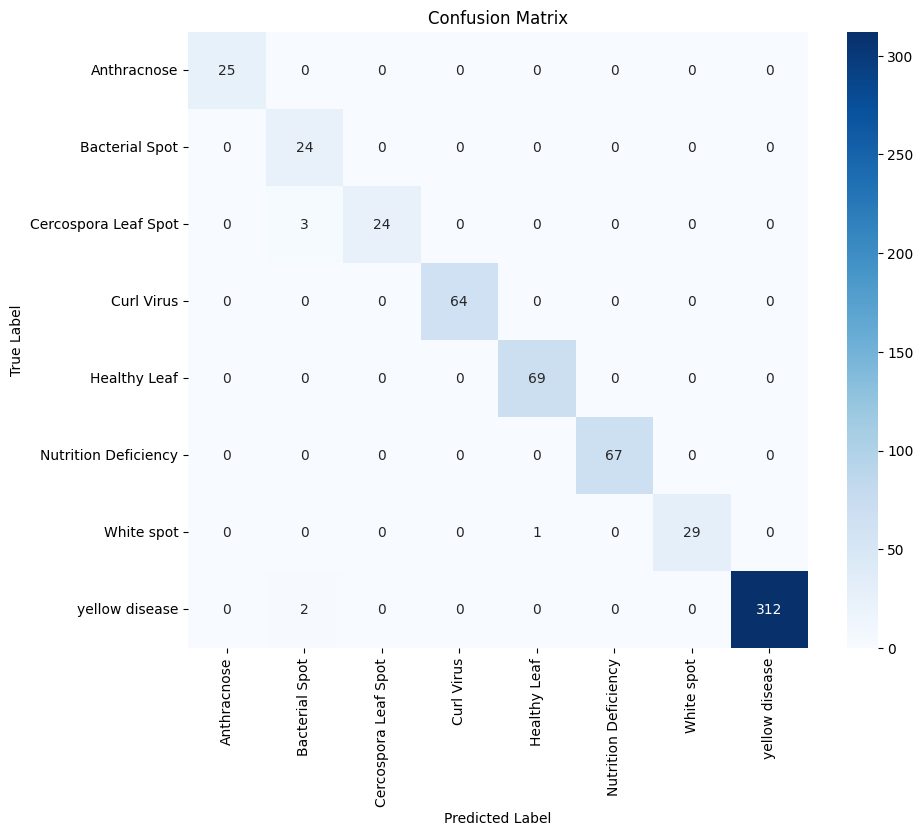

In [14]:
import seaborn as sns

#confusion matrix
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
#waktu inferensi
sample = next(iter(test_ds))[0]

start = time.time()
_ = model.predict(sample)
inference_time = (time.time() - start) / len(sample)

print("Inference Time per Image:", inference_time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Inference Time per Image: 0.00620599091053009


In [19]:
#ukuran file model
size_mb = os.path.getsize(best_info["Model Path"]) / (1024*1024)
print("Model Size (MB):", size_mb)

Model Size (MB): 17.27587890625


In [23]:
train_acc = history2.history['accuracy'][-1]
val_acc = history2.history['val_accuracy'][-1]

if train_acc - val_acc > 0.10:
    print(f"⚠ Overfitting detected: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")
elif val_acc > train_acc:
    print(f"⚠ Possible underfitting: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")
else:
    print(f"✔ Model stable: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

✔ Model stable: Train Acc = 0.9895, Val Acc = 0.9870


In [25]:
import csv

# Create a dictionary to hold all metrics
metrics = {
    "Experiment_Name": EXPERIMENT_NAME,
    "Test_Accuracy": test_acc,
    "Test_Loss": test_loss,
    "Inference_Time_per_Image": inference_time,
    "Model_Size_MB": size_mb,
    "Train_Accuracy_Final": train_acc,
    "Validation_Accuracy_Final": val_acc
}

# Convert classification report to a dictionary for easier saving
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
metrics["Classification_Report"] = report_dict

# Convert confusion matrix to a list of lists or string for saving
metrics["Confusion_Matrix"] = cm.tolist()

# Append to results CSV
file_exists = os.path.isfile(RESULTS_FILE)
with open(RESULTS_FILE, 'a', newline='') as f:
    writer = csv.writer(f)
    if not file_exists:
        writer.writerow(metrics.keys())
    writer.writerow([json.dumps(v) if isinstance(v, (dict, list)) else v for v in metrics.values()])

print("Evaluation results saved to:", RESULTS_FILE)

Evaluation results saved to: /content/drive/MyDrive/Seminar Hasil/Experiments/Two_Stage_Training/results.csv


In [26]:
inference_time_ms = inference_time * 1000
print(f"Inference Time per Image: {inference_time_ms:.3f} ms")

Inference Time per Image: 6.206 ms
